## Libraries & Data load

In [14]:
import re
import pickle
import pandas as pd

import pyLDAvis.gensim
import nltk
from nltk.tokenize import casual

import gensim
from gensim import corpora, models, similarities, matutils

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline

In [30]:
# Data downloaded from https://www.kaggle.com/thoughtvector/customer-support-on-twitter/version/10#twcs.zip

df = pd.read_csv('/Users/ridha.soedarsono/ds/metis/metis-w7/customer-support-on-twitter/twcs.zip')

## Preprocessing

* Isolate customer's initial English AmazonHelp inquiry 
* Preprocess Text; clean, expand contractions, & stem (lemmatizing caused similar words to appear repeatedly e.g. delivery & deliver)
* Additional Stopwords
* Vectorizing text using CountVectorizer

In [16]:
df_amazon = df[(df.text.str.contains('AmazonHelp') == True) | (df.author_id == 'AmazonHelp')]
df_amazon.reset_index(inplace=True)
df_amazon.head(5)

,index,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,181,269,AmazonHelp,False,Wed Nov 22 09:23:01 +0000 2017,@115770 こんにちは、アマゾン公式です。Fire TV Stickが見れないというのは、どのような状況でしょうか。一般的なトラブルシューティングを記載したヘルプがございますので、ご参照ください。https://t.co/2pbG55qJ7h ET,"270,271",272.0
1,182,270,115770,True,Wed Nov 22 09:24:30 +0000 2017,@AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。,NaN,269.0
2,183,271,115770,True,Wed Nov 22 09:30:36 +0000 2017,@AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎてるので買い直しになるんでしょうね。,273,269.0
3,184,273,AmazonHelp,False,Wed Nov 22 09:40:27 +0000 2017,@115770 カスタマーサービスにてお問い合わせ済みとのことで、お手数をおかけいたしました。リプライいただきありがとうございました。ET,274,271.0
4,185,274,115770,True,Wed Nov 22 09:44:04 +0000 2017,@AmazonHelp こちらこそありがとうございました。,275,273.0


In [6]:
# Detecting language -- ~30 min to finish!
import langdetect
langdetect.DetectorFactory.seed = 0

language = []
lang_error_count = 0

for tweet in df_amazon.text:
    try:
        language.append(langdetect.detect(tweet))
    except:
        language.append('Error')
        lang_error_count += 1
        
df_amazon['language'] = language

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Language detection takes 30 min to finish, resulting dataframe was pickled

In [10]:
# Continue after language detection
#df_amazon.to_pickle('/Users/ridha.soedarsono/ds/metis/metis-w7/df_amazon.pkl')
df_amazon = pd.read_pickle('/Users/ridha.soedarsono/ds/metis/metis-w7/df_amazon.pkl')

In [11]:
# Filter English only
df_amazon_en = df_amazon[df_amazon.language == 'en'].reset_index(drop=True)

# Convert date to datetime
df_amazon_en['date'] = pd.to_datetime(df_amazon_en.created_at.str.slice(26,30) + ' ' + df_amazon_en.created_at.str.slice(4,10))
#df_amazon_en.drop('created_at', axis=1, inplace=True)

# Isolating first complain
df_amazon_en_complain = df_amazon_en[df_amazon_en.in_response_to_tweet_id.isna()].reset_index(drop=True)

In [31]:
df_amazon_en_complain.head()

,index,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,language,date
0,340,634,115831,True,Tue Oct 31 21:39:58 +0000 2017,@115821 @AmazonHelp why is my order at my local courier for the last 6 days and still hasn’t been delivered to me?? Over 1 week late 😡,633,NaN,en,2017-10-31
1,349,643,115834,True,Mon Oct 30 23:44:45 +0000 2017,"Bought an @115821 Echo Show and it won’t recognize a single @AmazonHelp account in our household. WTF, guys?",642,NaN,en,2017-10-30
2,353,646,115835,True,Tue Oct 31 21:40:30 +0000 2017,.@AmazonHelp Item has not been delivered but tracking says it was handed to me over an hour ago... 2nd time this has happened. Sort it out https:/...,644,NaN,en,2017-10-31
3,361,652,115838,True,Tue Oct 31 22:11:15 +0000 2017,@AmazonHelp Is it possible to prevent AMZL from delivering my packages moving forward? Stuff is either lost/stolen/broken EVERY time.,650,NaN,en,2017-10-31
4,370,664,115842,True,Tue Oct 31 21:50:49 +0000 2017,"@AmazonHelp delivery I paid for today,didn’t arrive.why not?i paid enough for it.where is it??I’m unhappy.refund the delivery charge",663,NaN,en,2017-10-31


In [12]:
# Text clean and stem
def preprocess(texts):
    import re
    # Remove @handlers, repeated-characters, & URL link
    text_clean_1 = [ re.sub(r"(?:\@|https?\://)\S+", "", casual.reduce_lengthening(casual.remove_handles(text)).strip().lower()) for text in texts]

    # Expand contractions
    text_clean_2 = []
    for text in text_clean_1:
        for word in text.split():
            if word in contractions:
                text = text.replace(word,contractions[word])
        text_clean_2.append(text)

    # Stemming; tokenize and re-join
    stem = nltk.stem.SnowballStemmer('english')
    
    text_clean_3 = []
    for text in text_clean_2:
        texts_ = []
        for word in text.split():
            texts_.append((stem.stem(word)))
        text_clean_3.append(' '.join(texts_))
        
    return text_clean_3

# Define contraction dictionary

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"service": "servic",
"parcel": "package",
"delivery": "deliver",
"delivered": "deliver",
"delivering": "deliver",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"i'd": "would",
"i'd've": "I would have",
"i'll": "I will",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"that'd": "that would",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
 'ain’t': 'am not',
 'aren’t': 'are not',
 'can’t': 'cannot',
 'can’t’ve': 'cannot have',
 '’cause': 'because',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'didn’t': 'did not',
 'doesn’t': 'does not',
 'don’t': 'do not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'he’ll': 'he will',
 'he’s': 'he is',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’ll': 'how will',
 'how’s': 'how has',
 'i’d': 'would',
 'i’d’ve': 'I would have',
 'i’ll': 'I will',
 'i’m': 'I am',
 'i’ve': 'I have',
 'isn’t': 'is not',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’s': 'it is',
 'let’s': 'let us',
 'ma’am': 'madam',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'o’clock': 'of the clock',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'she’ll': 'she will',
 'she’s': 'she is',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'that’d': 'that would',
 'that’s': 'that is',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'there’s': 'there is',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'they’ll': 'they will',
 'they’re': 'they are',
 'they’ve': 'they have',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’re': 'we are',
 'we’ve': 'we have',
 'weren’t': 'were not',
 'what’ll': 'what will',
 'what’re': 'what are',
 'what’s': 'what is',
 'what’ve': 'what have',
 'when’s': 'when is',
 'when’ve': 'when have',
 'where’d': 'where did',
 'where’s': 'where is',
 'where’ve': 'where have',
 'who’ll': 'who will',
 'who’s': 'who is',
 'who’ve': 'who have',
 'why’s': 'why is',
 'why’ve': 'why have',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'you’d': 'you would',
 'you’d’ve': 'you would have',
 'you’ll': 'you will',
 'you’re': 'you are',
 'you’ve': 'you have'}

In [13]:
from gensim.parsing.preprocessing import STOPWORDS

# Adding stopwords
stopwords_add = ['let', 'amazon', 'hi', 'hey', 'did', 'doe', 'amzl', 'amp', 'pls', 'plz', 'just', 'like', 'able', 'make', 'need', 'want', 'please', 'help', 'pleas', 'sorri', 'look', 'tell', 'ani', 'whi' ,'got', 'abl', 'someth', 'know', 'sure', 'tri', 'veri', 'realli', 'guy', 'guys', 'fuck', 'everi', 'mass', 'asap', 'share', 'mani']
stoplist = list(STOPWORDS)
stoplist.extend(stopwords_add)

# Running preprocess function
data = preprocess(df_amazon_en_complain.text)

# Vectorizer
cv_vect = CountVectorizer(max_df=0.95, token_pattern='(?u)\\b[a-z][a-z][a-z]+\\b', ngram_range=(1,2), stop_words=stoplist, min_df = 2)
cv_data = cv_vect.fit_transform(data)

## Topic Modelling

After experimenting CountVectorizer & TF-IDF with LSA, NMF, & LDA, best result was achieved on CountVectorizer & LDA. Topic clarity & distinction were best on this combination

In [17]:
def lda_model(word_vector, n_comp):
    counts = word_vector.transpose()
    corpus = matutils.Sparse2Corpus(counts)
    
    id2word = { identifier: word for word, identifier in cv_vect.vocabulary_.items()}
    dictionary = gensim.corpora.Dictionary.from_corpus(corpus, id2word)

    lda = models.LdaModel(corpus=corpus, num_topics=n_comp, id2word=id2word, passes=10, alpha='auto', random_state=10)

    lda_corpus = lda[corpus]
    lda_counts = matutils.corpus2csc(lda_corpus)
    result = lda_counts.transpose().toarray()
    
    return result, lda, corpus, dictionary

In [22]:
# Topic modelling in 14 topics
lda_14_cv_data, lda_14, corpus_14, dictionary_14 = lda_model(cv_data, 14)

# Visualize using pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_14, corpus_14, dictionary_14)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.282038 -0.089253       1        1  15.643220
8     -0.076748  0.172939       2        1   9.543001
9      0.205000 -0.093511       3        1   8.247190
7     -0.236290 -0.122276       4        1   8.244295
12    -0.065953 -0.179800       5        1   7.492355
2      0.148426  0.028735       6        1   6.386741
6      0.149232 -0.188261       7        1   6.313211
10    -0.047532  0.087818       8        1   6.122369
13    -0.044145  0.141323       9        1   5.853235
5      0.104441  0.026465      10        1   5.833772
11     0.112860 -0.068848      11        1   5.667977
4     -0.011521  0.066526      12        1   5.374920
1      0.006228  0.055441      13        1   4.658308
3      0.038039  0.162702      14        1   4.619412, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
4     Default  4663.000000           deliv  4663.000000  30.0000  30.0000
68    Default  2630.000000           prime  2630.000000  29.0000  29.0000
3     Default  2710.000000             day  2710.000000  28.0000  28.0000
0     Default  5061.000000           order  5061.000000  27.0000  27.0000
38    Default  2148.000000          packag  2148.000000  26.0000  26.0000
75    Default  1172.000000          servic  1172.000000  25.0000  25.0000
74    Default  1321.000000          custom  1321.000000  24.0000  24.0000
17    Default  1276.000000         account  1276.000000  23.0000  23.0000
51    Default   948.000000          refund   948.000000  22.0000  22.0000
47    Default  1483.000000           today  1483.000000  21.0000  21.0000
528   Default  1023.000000         product  1023.000000  20.0000  20.0000
306   Default   846.000000           arriv   846.000000  19.0000  19.0000
212   Default   861.000000          return   861.000000  18.0000  18.0000
78    Default   560.000000   custom servic   560.000000  17.0000  17.0000
23    Default  1532.000000            item  1532.000000  16.0000  16.0000
96    Default   756.000000          cancel   756.000000  15.0000  15.0000
153   Default  1049.000000           email  1049.000000  14.0000  14.0000
193   Default   552.000000            card   552.000000  13.0000  13.0000
52    Default   525.000000           charg   525.000000  12.0000  12.0000
120   Default  1096.000000            ship  1096.000000  11.0000  11.0000
109   Default  1233.000000          receiv  1233.000000  10.0000  10.0000
263   Default   760.000000             pay   760.000000   9.0000   9.0000
191   Default   386.000000             buy   386.000000   8.0000   8.0000
381   Default   365.000000            gift   365.000000   7.0000   7.0000
28    Default  1304.000000            time  1304.000000   6.0000   6.0000
230   Default   506.000000           money   506.000000   5.0000   5.0000
618   Default   401.000000            book   401.000000   4.0000   4.0000
83    Default   455.000000         support   455.000000   3.0000   3.0000
367   Default   396.000000         purchas   396.000000   2.0000   2.0000
133   Default   517.000000           place   517.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
2719  Topic14    29.596743           audio    30.400570   3.0481  -5.8575
189   Topic14    29.202080             hit    30.005909   3.0477  -5.8710
4715  Topic14    29.130449     battlefront    29.934277   3.0477  -5.8734
2424  Topic14    27.957504            wrap    28.761332   3.0466  -5.9145
1016  Topic14    26.099461      assistance    26.903290   3.0446  -5.9833
5136  Topic14    25.380610            sync    26.184441   3.0437  -6.0112
9016  Topic14    24.249229  customerservic    25.053061   3.0423  -6.0568
722   Topic14    71.815651          pickup    76.969452   3.0056  -4.9711
642   Topic14    65.177162           advis    79.621140   2

## Reducer, Clustering & t-SNE Plot

**Dimensionality reduction**:  
Clustering directly on 16 topics made the cluster into a single blob. After experimenting with different number of components with different reducers, best result were achieved by LDA with 35 components.

**Clustering**:  
Searching optimum cluster *k* value for KMeans through inertia & sillhouette coef. plot didn't yield expected result. The two plots were inconclusive (e.g. no 'kink' found for inertia vs. *k* number plot) for this data.  Additionally, observation through tSNE plot revealed a number of data separation but exact amount are difficult to identify. Experimenting directly with different *k* values for KMeans actually resulted well clustered data in tSNE plot. However when checking the data (tweet) within each cluster, it was difficult to recognize pattern or interpret the cluster topically.

Therefore clustering were done using DBSCAN

In [ ]:
# Reducer with 35 components
lda_35_cv_data, _, _, _ = lda_model(cv_data, 35)

# Running tSNE & DBSCAN
tsne = TSNE(n_components=2)
tsne_35_data = tsne.fit_transform(lda_35_cv_data)

dbs_lda = DBSCAN(eps=0.24, min_samples=180)
dbs_lda.fit(lda_35_cv_data)

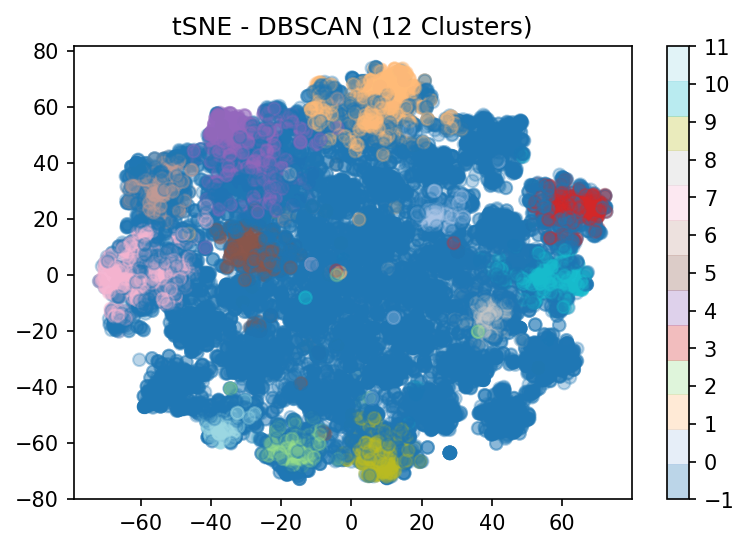

In [24]:
# tSNE Plot with DBSCAN's clusters
plt.figure(dpi=150)
plt.scatter(tsne_35_data[:,0], tsne_35_data[:,1], c=dbs_lda.labels_, alpha=0.3, cmap=cm.get_cmap('tab20', 13));
plt.title('tSNE - DBSCAN (12 Clusters)')
plt.colorbar(ticks = list(range(-1,12)))

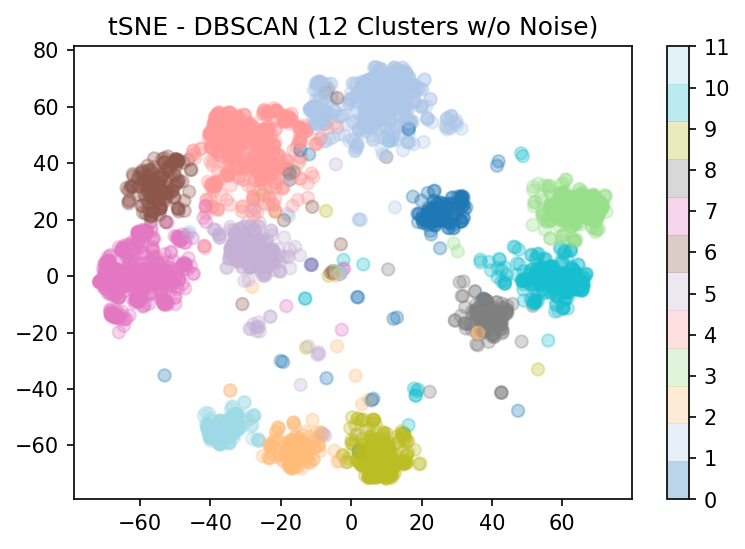

In [27]:
# tSNE Plot with DBSCAN's clusters & noise excluded
plt.figure(dpi=150)
plt.scatter(tsne_35_data[dbs_lda.labels_ != -1,0], tsne_35_data[dbs_lda.labels_ != -1,1], c=[i for i in dbs_lda.labels_ if i != -1], alpha=0.3, cmap=cm.get_cmap(name='tab20', lut=12));
plt.title('tSNE - DBSCAN (12 Clusters w/o Noise)')
plt.colorbar(ticks = list(range(0,12)))